In [1]:
import tensorflow as tf
import numpy as np

In [2]:
def reset_graph(seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
num_features = 3
num_neurons = 5
num_instances = 4
num_timesteps = 2

In [4]:
reset_graph(42)

In [5]:

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### RNN from scratch

In [6]:
# Input at first time step
x0 = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
# Input at second time step
x1 = tf.placeholder(dtype=tf.float32, shape=(None, num_features))

In [7]:
# The weights - input to neurons (num_features x num_neurons)
wx = tf.Variable(initial_value=tf.random_normal(shape=(num_features, num_neurons)), dtype=tf.float32)
# The biases - neurons to output (num_neurons x num_neurons)
wy = tf.Variable(initial_value=tf.random_normal(shape=(num_neurons, num_neurons)), dtype=tf.float32)

In [8]:
# Biases - one for each neuron (1 x num_neurons)
b = tf.Variable(initial_value=tf.zeros((1, num_neurons)), dtype=tf.float32)

In [9]:
# Output of first time step
y0 = tf.tanh(tf.matmul(x0, wx) + b)
# Output of second time step
y1 = tf.tanh(tf.matmul(y0, wy) + tf.matmul(x1, wx) + b)

In [10]:
print(x0.shape)
print(x1.shape)
print(wx.shape)
print(wy.shape)
print(b.shape)
print(y0.shape)
print(y1.shape)

(?, 3)
(?, 3)
(3, 5)
(5, 5)
(1, 5)
(?, 5)
(?, 5)


In [11]:
x0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
x1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

In [12]:
init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    sess.run(init)
    op0, op1 = sess.run([y0, y1], feed_dict={x0: x0_batch, x1: x1_batch})

In [14]:
op0

array([[-0.06640061,  0.96257669,  0.68105787,  0.70918542, -0.89821595],
       [ 0.99777555, -0.71978879, -0.99657613,  0.96739244, -0.99989706],
       [ 0.99999785, -0.99898809, -0.99999887,  0.99677628, -0.99999988],
       [ 1.        , -1.        , -1.        , -0.99818921,  0.99950868]], dtype=float32)

In [15]:
op1

array([[ 1.        , -1.        , -1.        ,  0.40200272, -0.99999994],
       [-0.12210429,  0.62805295,  0.96718436, -0.99371219, -0.25839329],
       [ 0.99999815, -0.9999994 , -0.99999744, -0.85943311, -0.99998796],
       [ 0.99928296, -0.99999809, -0.99990588,  0.98579615, -0.92205751]], dtype=float32)

In [16]:
show_graph(tf.get_default_graph())

### RNN using static_rnn()

In [17]:
reset_graph(42)

In [18]:
x = tf.placeholder(dtype=tf.float32, shape=(None, num_timesteps, num_features))
x_seqs = tf.unstack(tf.transpose(x, perm=[1, 0, 2]))

In [19]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, x_seqs, dtype=tf.float32)
outputs = tf.stack(tf.transpose(output_seqs, perm=[1, 0, 2]))

In [20]:
x_batch = np.array([
    [[0, 1, 2], [9, 8, 7]],
    [[4, 5, 6], [0, 0, 0]],
    [[7, 8, 9], [3, 4, 5]],
    [[9, 0, 1], [6, 7, 8]]
])

In [21]:
init = tf.global_variables_initializer()

In [22]:
with tf.Session() as sess:
    sess.run(init)
    output_vals = sess.run(outputs, feed_dict={x: x_batch})

In [23]:
print(output_vals)

[[[-0.45652321 -0.68064117  0.40938237  0.63104498 -0.45732823]
  [-0.94288003 -0.99988687  0.94055808  0.99999845 -0.99999976]]

 [[-0.86200124 -0.99784923  0.84966648  0.99946117 -0.99940377]
  [-0.66212511  0.10668644  0.57903773  0.45356435 -0.64771992]]

 [[-0.95685041 -0.99995553  0.95359546  0.99999654 -0.99999714]
  [-0.9611541  -0.99056184  0.93603456  0.99899662 -0.99928254]]

 [[ 0.99273676 -0.99819332 -0.55543649  0.99890316 -0.9953323 ]
  [-0.92453992 -0.99976921  0.98757124  0.99998409 -0.99998546]]]


In [24]:
show_graph(tf.get_default_graph())

### RNN using dynamic_rnn() with sequence_length

In [25]:
reset_graph(42)

In [26]:
x = tf.placeholder(dtype=tf.float32, shape=(None, num_timesteps, num_features))
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32, sequence_length=seq_length)

In [27]:
init = tf.global_variables_initializer()

In [28]:
x_batch = np.array([
    [[0, 1, 2], [9, 8, 7]],
    [[4, 5, 6], [0, 0, 0]],
    [[7, 8, 9], [3, 4, 5]],
    [[9, 0, 1], [6, 7, 8]]
])

seq_length_batch = np.array([2, 1, 2, 2])

In [29]:
with tf.Session() as sess:
    sess.run(init)
    output_val = sess.run(outputs, feed_dict={x:x_batch, seq_length: seq_length_batch})

In [30]:
output_val

array([[[ 0.73155701,  0.3483572 ,  0.50582004, -0.22882834, -0.44022721],
        [-0.61832327,  0.99999994,  0.865848  ,  0.97933763,  0.99022454]],

       [[ 0.87053078,  0.99955684,  0.90130299,  0.59886342,  0.27432424],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.92714554,  0.99999863,  0.97429484,  0.88198107,  0.68953514],
        [ 0.51778507,  0.98942834,  0.99259269, -0.25857043, -0.15511438]],

       [[-0.99952275,  0.99977851,  0.5974465 ,  0.99309695,  0.99847412],
        [ 0.89361316,  0.9995628 ,  0.99916047,  0.40445158, -0.18050136]]], dtype=float32)

In [31]:
show_graph(tf.get_default_graph())

### Training an RNN (to recognize mnist dataset)

In [32]:
reset_graph(42)

In [33]:
num_features = 28
num_timesteps = 28
num_neurons = 150
num_outputs = 10

learning_rate = 0.001

In [34]:
x = tf.placeholder(dtype=tf.float32, shape=(None, num_timesteps, num_features))
y = tf.placeholder(dtype=tf.int32, shape=(None))

In [35]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)

In [36]:
logits = tf.layers.dense(states, num_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [37]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/home/anand/.tensorflow/data/MNIST")

Extracting /home/anand/.tensorflow/data/MNIST/train-images-idx3-ubyte.gz
Extracting /home/anand/.tensorflow/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /home/anand/.tensorflow/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /home/anand/.tensorflow/data/MNIST/t10k-labels-idx1-ubyte.gz


In [38]:
x_test = mnist.test.images.reshape((-1, num_timesteps, num_features))
y_test = mnist.test.labels

In [39]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            x_batch = x_batch.reshape((-1, num_timesteps, num_features))
            sess.run(training_op, feed_dict={x: x_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={x: x_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: x_test, y: y_test})
        print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)

0 Train accuracy:  0.946667 Test accuracy:  0.9366
1 Train accuracy:  0.966667 Test accuracy:  0.9487
2 Train accuracy:  0.966667 Test accuracy:  0.9602
3 Train accuracy:  0.96 Test accuracy:  0.9594
4 Train accuracy:  0.946667 Test accuracy:  0.9632
5 Train accuracy:  0.966667 Test accuracy:  0.9702
6 Train accuracy:  0.973333 Test accuracy:  0.9688
7 Train accuracy:  0.986667 Test accuracy:  0.9703
8 Train accuracy:  0.933333 Test accuracy:  0.9647
9 Train accuracy:  0.986667 Test accuracy:  0.9686
10 Train accuracy:  0.973333 Test accuracy:  0.9566
11 Train accuracy:  0.953333 Test accuracy:  0.9724
12 Train accuracy:  0.986667 Test accuracy:  0.9748
13 Train accuracy:  0.98 Test accuracy:  0.9705
14 Train accuracy:  0.973333 Test accuracy:  0.9725
15 Train accuracy:  1.0 Test accuracy:  0.9737
16 Train accuracy:  1.0 Test accuracy:  0.976
17 Train accuracy:  0.986667 Test accuracy:  0.9753
18 Train accuracy:  0.973333 Test accuracy:  0.9654
19 Train accuracy:  0.98 Test accuracy:  

Test individually

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

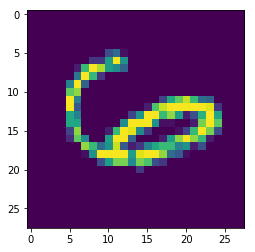

[[-0.37202415 -0.26540419  0.08647861 -0.0771862  -0.27124536 -0.14065874
  -0.16054773  0.05139041  0.4317694  -0.43896386]]
Actual 6 Predicted 8


In [41]:
idx = 3222

plt.imshow(np.array(x_test[idx]).reshape(num_timesteps, num_features))
plt.show()

x1 = np.array(x_test[idx]).reshape(-1, num_timesteps, num_features)
y1 = y_test[idx]

with tf.Session() as sess:
    sess.run(init)
    o1 = sess.run(logits, feed_dict={x: x1})
    

print(o1)
print('Actual', y1, 'Predicted', np.argmax(o1[0]))

### Training an RNN (to recognize mnist dataset) using multiple layers

In [43]:
num_layers = 3
num_features = 28
num_timesteps = 28
num_neurons = 150
num_outputs = 10
learning_rate = 0.001

In [44]:
x = tf.placeholder(dtype=tf.float32, shape=(None, num_timesteps, num_features))
y = tf.placeholder(dtype=tf.int32, shape=(None))

In [45]:
layers = [tf.contrib.rnn.BasicRNNCell(num_neurons, activation=tf.nn.relu) for l in range(num_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)

In [47]:
states_concat = tf.concat(states, axis=1)
logits = tf.layers.dense(states_concat, num_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss= tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [48]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            x_batch = x_batch.reshape((-1, num_timesteps, num_features))
            sess.run(training_op, feed_dict={x: x_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={x: x_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: x_test, y: y_test})
        print(epoch, 'Train accuracy', acc_train, 'Test accuracy', acc_test)

0 Train accuracy 0.973333 Test accuracy 0.9513
1 Train accuracy 0.986667 Test accuracy 0.9717
2 Train accuracy 0.973333 Test accuracy 0.9721
3 Train accuracy 0.986667 Test accuracy 0.9785
4 Train accuracy 0.986667 Test accuracy 0.9753
5 Train accuracy 1.0 Test accuracy 0.9818
6 Train accuracy 1.0 Test accuracy 0.9849
7 Train accuracy 0.986667 Test accuracy 0.9842
8 Train accuracy 0.993333 Test accuracy 0.9847
9 Train accuracy 0.993333 Test accuracy 0.9767
